# <div align="center"><b> ОПРЕДЕЛЕНИЕ ПЕРСПЕКТИВНОГО ТАРИФА ДЛЯ ТЕЛЕКОМ-КОМПАНИИ</b></div> 

Компания "Мегалайн" обеспечивает поддержку двух тарифных планов: Smart и  Ultra. Для корректировки рекламного бюджета на основании данных о пользовательском поведении 500 абонентов в 2018 г. необходимо выявить, какой тариф является наиболее рентабельным. 

# 1. Предобработка данных

С целью получения корректных результатов исследования на этапе предобработки данных должно быть выполнено следующее:
- получение общей информации о данных, выявление возможных проблем;
- поиск и устранение аномальных значений (при необходимости);
- поиск и устранение пропусков (при необходимости);
- поиск и устранение явных и неявных дубликатов;
- корректировка типов данных (при необходимости).

## 1.1 Обзор данных

In [5]:
#импорт библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

In [6]:
#снимем ограничение на количество столбцов датафрейма, выводимых на экран
pd.options.display.max_columns = None

In [7]:
#прочитаем файл с информацией о пользователях, сохраним в переменную df_users
try:
    # local machine
    df_users = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_4_tariffs_analysis\datasets\users.csv')
except:
    #yandex practicum server
    df_users = pd.read_csv('/datasets/users.csv')
    
#выведем на экран первые 5 строк датафрейма df_users
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
#получим общую информацию о df_users
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**Выводы по датасету *df_users*:** <a id = 'concl_df_users'></a>
- датасет, содержащий информацию о пользователях, содержит 500 строк и 7 столбцов;
- пропуски наблюдаются только в столбце `churn_date` - дата прекращения пользования тарифом, что связано с тем, что на момент выгрузки данных тариф все еще действовал;
- несоответствие типов данных наблюдается для столбцов `churn_date` (должен быть тип datetime), `reg_date` (должен быть тип datetime).

Для дальнейшей работы с датасетом *df_users* требуется:
- привести столбцы `churn_date` и `reg_date` к формату datetime;
- выполнить поиск аномальных значений;
- проверить датасет на явные и неявные дубликаты, в том числе по столбцам `user_id`, `city`, `tariff`.

In [9]:
#прочитаем файл с информацией о звонках, сохраним в переменную df_calls
try:
    # local machine
    df_calls = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_4_tariffs_analysis\datasets\calls.csv')
except:
    #yandex practicum server
    df_calls = pd.read_csv('/datasets/calls.csv')
    
#выведем на экран первые 5 строк датафрейма df_calls
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
#получим общую информацию о df_calls
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Выводы по датасету *df_calls*:** <a id = 'concl_df_calls'></a>
- датасет с информацией о звонках содержит 202607 строк и 4 столбца;
- пропуски в датасете отсутствуют;
- для столбца `call_date` наблюдается несоответствие типа данных (должен быть формат datetime).

Для дальнейшей работы с *df_calls* необходимо:
- привести столбец `call_date` к формату datetime;
- провести проверку датасета на наличие дубликатов;
- провести проверку датасета на наличие аномальных значений;
- согласно условиям компании "Мегалайн", все звонки округляются до минут. В связи с этим необходимо добавить еще один столбец, в котором продолжительность звонков из `call_durate` будет округлена до минут (в большую сторону).

In [11]:
#прочитаем файл с информацией о сообщениях, сохраним в переменную df_messages
try:
    # local machine
    df_messages = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_4_tariffs_analysis\datasets\messages.csv')
except:
    #yandex practicum server
    df_messages = pd.read_csv('/datasets/messages.csv')
    
#выведем на экран первые 5 строк датафрейма df_messages
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
#получим общую информацию о df_messages
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Выводы по датасету *df_messages*:** <a id = 'concl_df_messages'></a>
- датасет содержит 123035 строк и 3 столбца;
- пропуски отсутствуют;
- наблюдается несоответствие формата столбца `mesage_date` (должен быть тип datetime).

Для дальнейшей работы с *df_messages* необходимо:
- привести столбец `message_date` к формату datetime;
- выполнить проверку датасета на дубликаты и аномальные значения.

In [13]:
#прочитаем файл с информацией об интернет траффике, сохраним в переменную df_internet
try:
    # local machine
    df_internet = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_4_tariffs_analysis\datasets\internet.csv')
except:
    #yandex practicum server
    df_internet = pd.read_csv('/datasets/internet.csv')
    
#выведем на экран первые 5 строк датафрейма df_internet
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [14]:
#получим общую информацию о df_internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**Выводы по датасету *df_internet*:** <a id = 'concl_df_internet'></a>
- датасет содержит 149396 строк и 5 столбцов;
- пропуски в датасете отсутствуют;
- тип данных в столбце `session_date` не соответствует формату datetime;
- в датасете присутствует лишний столбец `Unnamed: 0`

Для дальнейшей работы с датасетом *df_internet* необходимо:
- привести данные в столбце `session_date` к формату datetime;
- проверить датасет на аномальные значения и дубликаты;
- удалить столбец `Unnamed: 0` (вероятно, он дублирует индексы строк датафрейма, поэтому перед удалением следует проверить предположение).

In [15]:
#прочитаем файл с информацией об интернет траффике, сохраним в переменную df_tariffs
try:
    # local machine
    df_tariffs = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_4_tariffs_analysis\datasets\tariffs.csv')
except:
    #yandex practicum server
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    
#выведем на экран df_tariffs
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
#получим общую информацию о df_tariffs
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Выводы по *df_tariffs*:**
- в датафрейме 2 строки и семь столбцов;
- все типы данных в датафрейме корректны;
- пропуски отсутствуют, информация о тарифах приведена полностью;
- предобработка данных в *df_tariffs* не требуется.

## 1.2 Предобработка данных датафрейма *df_users*

### 1.2.1 Изменение типов данных датафрейма *df_users*

Исходя из [анализа общей информации о датафрейме *df_users*](#concl_df_users), данные столбцов `churn_date` и `reg_date` необходимо привести к типу datetime.

In [17]:
#для получения информации о способе записи даты в столбце churn_date выведем на экран строки, для которых значение в этом
#столбце не является пропуском
df_users[~df_users['churn_date'].isna()].head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


Способ записи даты в `churn_date` и в `reg_date` один и тот же: год-месяц-день. Преобразуем данные в указанных столбцах в формат datetime, используя метод библиотеки pandas to_datetime().

In [18]:
#приведем данные столбца churn_date к формату datetime
df_users['churn_date']=pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

#приведем данные столбца reg_date к формату datetime
df_users['reg_date']=pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

#проверим результат
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### 1.2.2 Поиск аномальных значений в *df_users*

Исходя из [анализа общей информации о датафрейме *df_users*](#concl_df_users), необходимо выполнить поиск аномальных значений в наборе данных:
- для анализа данных в столбцах `user_id`, `age` воспользуемся методом describe();
- для поиска аномальных значений в столбцах `churn_date` и `reg_date` выявим самую раннюю и самую позднюю записи и убедимся, что полученный результат соответствует 2018 году.
- для поиска аномальных значений в столбцах `city` и `tariff` воспользуемся методом unique();
- поиск аномалий в столбцах с именем и фамилией пользователя (`first_name` и `last_name` соответственно) выполнять не будем, так как в рамках исследования это не имеет значения.

In [19]:
#получим статистическую информацию о столбцах user_id и age
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Аномалий в столбцах `user_id` и `age` не выявлено:
- в столбце `user_id` находится 500 значений от 1000 до 1499 включительно;
- минимальный возраст пользователя - 18 лет, максимальный - 75 лет, что может соответствовать действительности.

In [20]:
#выполним проверку на аномалии для столбца churn_date
print('Самая ранняя дата прекращения пользования тарифом:', df_users['churn_date'].min())
print('Самая поздняя дата прекращения пользования тарифом:', df_users['churn_date'].max())

#выполним проверку на аномалии для столбца reg_date
print('Самая ранняя дата подключения:', df_users['reg_date'].min())
print('Самая поздняя дата подключения:', df_users['reg_date'].max())

Самая ранняя дата прекращения пользования тарифом: 2018-08-17 00:00:00
Самая поздняя дата прекращения пользования тарифом: 2018-12-30 00:00:00
Самая ранняя дата подключения: 2018-01-01 00:00:00
Самая поздняя дата подключения: 2018-12-31 00:00:00


Все записи в столбцах `churn_date` и `reg_date` соответствуют 2018 году, аномалий нет.

In [21]:
#выведем на экран уникальные значения столбца city
df_users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [22]:
#выведем на экран уникальные значения столбца tariff
df_users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Аномальных значений (и неявных дубликатов) в столбцах `city` и `tariff` не обнаружено.

### 1.2.3 Поиск дубликатов в *df_users*

На этапе поиска аномальных значений было выявлено, что неявные дубликаты в столбцах `city` и `tariff` отсутствуют. Проверим, есть ли дубликаты в столбце `user_id`.

In [23]:
#проверим количество уникальных значений в `user_id`
print('Уникальных значений в user_id:', len(df_users['user_id'].unique()))

Уникальных значений в user_id: 500


Количество уникальных значений в `user_id` соответствует количеству строк *df_users*. Соответственно, дубликатов в `user_id` нет, и каждому пользователю соответствует свой id (конечно, может возникнуть ситуация, при которой одному пользователю назначены два разных id, но информации для проверки такой ошибки недостаточно. Примем, что никаких сбоев в системе не возникло). Так как нет дубликатов в `user_id`, строки-дубликаты также отсутствуют.

## 1.3 Предобработка данных датафрейма *df_calls*

### 1.3.1 Изменение типов данных датафрейма *df_calls*

Исходя из [анализа общей информации о датафрейме *df_calls*](#concl_df_calls), данные столбца `call_date` необходимо привести к типу datetime.

In [24]:
#приведем данные столбца call_date к формату datetime
df_calls['call_date']=pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

#проверим результат
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Формат данных столбца `call_date` успешно изменен.

### 1.3.2 Поиск аномальных значений в *df_calls*

- для анализа значений в столбцах `duration` и `user_id` воспользуемся методом describe();
- для поиска аномалий в столбце `call_date` наидем самый ранний и самый поздний звонок. Они должны соответствовать 2018 году.
- поиск аномалий в столбце `id` выполнять не будем, так как в дальнейших операциях эта информация не имеет значения.

In [25]:
#получим статистическую информацию о столбцах duration и  user_id
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Минимальная продолжительность разговора соответствует 0 минутам - пропущенный вызов, максимальная - 38 минутам, что может соответствовать действительности. Минимальное значений user_id: 1000, максимальное: 1499, что соответствует значениям `df_users['user_id']`. Аномалий нет.

In [26]:
#выполним проверку на аномалии для столбца call_date
print('Самая ранняя дата совершения звонка:', df_calls['call_date'].min())
print('Самая поздняя дата совершения звонка:', df_calls['call_date'].max())

Самая ранняя дата совершения звонка: 2018-01-01 00:00:00
Самая поздняя дата совершения звонка: 2018-12-31 00:00:00


Все звонки в *df_calls* соответствуют 2018 году. Аномалий нет.

### 1.3.3 Поиск дубликатов в *df_calls*

Так как содержащиеся в df_calls данные не предполагают наличия неявных дубликатов, сразу выполним проверку на наличие полных дубликатов:

In [27]:
print('Полных дубликатов в df_calls:', df_calls.duplicated().sum())

Полных дубликатов в df_calls: 0


Дубликаты в *df_calls* отсутствуют.

### 1.3.4 Округление продолжительности звонков до минут

Согласно заданиию на проект, компания "Мегалайн" округляет продолжительность звонков до минут. Так как в столбце `duration` длительность звонков приведена в долях минут, округлим длительность звонков до целых минут в большую сторону (так как 1 секунда при звонке округляется до минуты). Результат сохраним в новый столбец.

In [28]:
#округлим значения столбца duration в большую сторону и сохраним результат в новый столбцец
df_calls['durations_minutes']=df_calls['duration'].apply(np.ceil)

#проверим результат
df_calls.head(10)

,id,call_date,duration,user_id,durations_minutes
0,1000_0,2018-07-25,0.00,1000,0.0
1,1000_1,2018-08-17,0.00,1000,0.0
2,1000_2,2018-06-11,2.85,1000,3.0
3,1000_3,2018-09-21,13.80,1000,14.0
4,1000_4,2018-12-15,5.18,1000,6.0
5,1000_5,2018-11-02,0.00,1000,0.0
6,1000_6,2018-10-18,0.00,1000,0.0
7,1000_7,2018-08-22,18.31,1000,19.0
8,1000_8,2018-09-15,18.44,1000,19.0
9,1000_9,2018-08-15,0.00,1000,0.0


Функция округления сработала корректно. Проверим тип данных нового столбца:

In [29]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 202607 non-null  object        
 1   call_date          202607 non-null  datetime64[ns]
 2   duration           202607 non-null  float64       
 3   user_id            202607 non-null  int64         
 4   durations_minutes  202607 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 7.7+ MB


Формат нового столбца `duration_minutes` float64. Переведем его в тип данных `'int'`:

In [30]:
df_calls['durations_minutes']=df_calls['durations_minutes'].astype('int')

#проверим результат
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 202607 non-null  object        
 1   call_date          202607 non-null  datetime64[ns]
 2   duration           202607 non-null  float64       
 3   user_id            202607 non-null  int64         
 4   durations_minutes  202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


Формат столбца `duration_minutes` изменен на `int`.

## 1.4 Предобработка данных датафрейма *df_messages*

### 1.4.1 Изменение типов данных датафрейма *df_messages*

Исходя из [анализа общей информации о датафрейме *df_messages*](#concl_df_messages), данные столбца `message_date` необходимо привести к типу datetime.

In [31]:
#приведем данные столбца call_date к формату datetime
df_messages['message_date']=pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

#проверим результат
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Формат данных столбца `message_date` успешно изменен.

### 1.4.2 Поиск аномальных значений в *df_messages*

- для анализа значений `user_id` воспользуемся методом describe();
- для поиска аномалий в столбце `message_date` наидем самую раннюю и самую позднюю sms. Они должны соответствовать 2018 году;
- поиск аномалий в столбце `id` выполнять не будем, так как в дальнейших операциях эта информация не имеет значения.

In [32]:
#получим статистическую информацию о столбце user_id
df_messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Минимальное значений user_id: 1000, максимальное: 1499, что соответствует значениям `df_users['user_id']`. Аномалий нет.

In [33]:
#выполним проверку на аномалии для столбца message_date
print('Самая ранняя дата отправления sms:', df_messages['message_date'].min())
print('Самая поздняя дата отправления sms:', df_messages['message_date'].max())

Самая ранняя дата отправления sms: 2018-01-02 00:00:00
Самая поздняя дата отправления sms: 2018-12-31 00:00:00


Все даты отправления sms-сообщений соответствуют 2018 году. Аномалий нет.

### 1.4.3 Поиск дубликатов в *df_messages*

Так как содержащиеся в df_messages данные не предполагают наличия неявных дубликатов, сразу выполним проверку на наличие полных дубликатов:

In [34]:
print('Полных дубликатов в df_messages:', df_messages.duplicated().sum())

Полных дубликатов в df_messages: 0


Полные дубликаты в *df_messages* отсутствуют.

## 1.5 Предобработка данных датафрейма *df_internet*

### 1.5.1 Изменение типов данных в *df_internet*

Исходя из [анализа общей информации о датафрейме *df_internet*](#concl_df_internet), данные столбца `session_date` необходимо привести к типу datetime.

In [35]:
#приведем данные столбца session_date к формату datetime
df_internet['session_date']=pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

#проверим результат
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Тип данных столбца `session_date` успешно изменен.

### 1.5.2 Поиск аномальных значений в *df_internet*

- для анализа значений `user_id`, `mb_used` воспользуемся методом describe();
- для поиска аномалий в столбце `session_date` наидем самую раннюю и самую позднюю интернет-сессию. Они должны соответствовать 2018 году;
- поиск аномалий в столбце `id` выполнять не будем, так как в дальнейших операциях эта информация не имеет значения.

In [36]:
#получим статистическую информацию о столбцах user_id и mb_used
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Минимальное количество траффика составляет 0 Мб, максимальное - 1.7 Гб. Аномальные значения в `mb_used` отсутствуют. Минимальное значений user_id: 1000, максимальное: 1499, что соответствует значениям `df_users['user_id']`. Аномалий нет.

In [37]:
#выполним проверку на аномалии для столбца session_date
print('Самая ранняя дата интернет-сессии:', df_internet['session_date'].min())
print('Самая поздняя дата интернет-сессии:', df_internet['session_date'].max())

Самая ранняя дата интернет-сессии: 2018-01-01 00:00:00
Самая поздняя дата интернет-сессии: 2018-12-31 00:00:00


Даты всех интернет-сессий соответствуют 2018 году. Аномалий нет.

### 1.5.3 Поиск дубликатов в *df_internet*

Так как содержащиеся в df_internet данные не предполагают наличия неявных дубликатов, сразу выполним проверку на наличие полных дубликатов:

In [38]:
print('Полных дубликатов в df_internet:', df_internet.duplicated().sum())

Полных дубликатов в df_internet: 0


Полные дубликаты в *df_internet* отсутствуют.

### 1.5.4 Удаление столбца *df_internet['Unnamed: 0']*

На этапе [анализа общей информации о датафрейме *df_internet*](#concl_df_internet) было выявлено, что *df_internet* содержит лишний столбец `Unnamed: 0`. Вероятно, этот столбец возник при выгрузке данных об абонентах и соответствует индексам строк датафрейма. 

В пункте 1.5.2 (при получении статистической информации о `mb_used` и `user_id`) было выявлено, что минимальному значению столбца `Unnamed: 0` соответствует 0, максимальному - 149395 (максимальный индекс строки). Если предположение, что значения столбца `Unnamed: 0` соответствуют индексам строк, верно, то в данном столбце нет ни одного дубликата. Проверим:

In [39]:
len(df_internet['Unnamed: 0'].unique())

149396

Количество уникальных значений в  `Unnamed: 0` соответствует количеству строк в содержащем его датафрейме. Предположение верно, столбец можно удалить.

In [40]:
#удалим столбец Unnamed: 0
df_internet.pop('Unnamed: 0')

#проверим результат
df_internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

Лишний столбец в *df_internet* удален.

<div class="alert-success"> 
<b>Комментарий ревьюера 👍</b> Все необходимые пункты в шаге выполнены :)

# 2. Расчет ежемесячных показателей для каждого пользователя

Согласно заданию на проект, для каждого пользователя необходимо рассчитать:
- количество звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- ежемесячный объем израсходованного интернет-трафика;
- ежемесячную выручку с каждого пользователя.

Для расчета необходимых показателей для каждой пользовательской операции (звонок, sms-сообщение, выход в интернет) определим месяц совершения, после чего создадим сводную таблицу с ежемесячной статистикой для каждого пользователя.

## 2.1 Определение месяца совершения операции

In [41]:
#определим месяцы совершения звонков
df_calls['month']=df_calls['call_date'].dt.month

#определим месяцы отправления сообщений
df_messages['month']=df_messages['message_date'].dt.month

#определим месяцы выхода в интернет
df_internet['month']=df_internet['session_date'].dt.month

In [42]:
#проверим результат для df_calls
df_calls.head()

,id,call_date,duration,user_id,durations_minutes,month
0,1000_0,2018-07-25,0.00,1000,0,7
1,1000_1,2018-08-17,0.00,1000,0,8
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12


In [43]:
#проверим результат для df_messages
df_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [44]:
#проверим результат для df_internet
df_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Месяцы совершения операций определены корректно.

## 2.2 Создание сводной таблицы с ежемесячной статистикой активности

In [45]:
#создадим сводную таблицу с ежемес. активностью и сохраним туда информацию о ежемесячной продолжительности звонков, количестве смс,
#объеме интернет-траффика
month_pivot_table=df_calls.pivot_table(index=['user_id', 'month'], values='durations_minutes', aggfunc=['count', 'sum']).join(
    [df_messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count'),
     df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')], how='outer').reset_index()
month_pivot_table

,user_id,month,"(count, durations_minutes)","(sum, durations_minutes)",message_date,mb_used
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91
...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,20579.36
3210,1499,9,9.0,70.0,11.0,1845.75
3211,1499,10,68.0,449.0,48.0,17788.51
3212,1499,11,74.0,612.0,59.0,17963.31


In [46]:
#добавим в сводную таблицу информацю о пользователях
month_pivot_table = month_pivot_table.merge(df_users, on='user_id', how='left')
month_pivot_table

,user_id,month,"(count, durations_minutes)","(sum, durations_minutes)",message_date,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
3210,1499,9,9.0,70.0,11.0,1845.75,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3211,1499,10,68.0,449.0,48.0,17788.51,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3212,1499,11,74.0,612.0,59.0,17963.31,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


In [47]:
#заменим названия столбцов, полученные в результате аггрегирования данных, на более удобные
month_pivot_table=month_pivot_table.rename(columns={('count', 'durations_minutes'):'calls_count', ('sum', 'durations_minutes'):'calls_duration', 'message_date':'messages_count'})
month_pivot_table.columns

Index(['user_id', 'month', 'calls_count', 'calls_duration', 'messages_count',
       'mb_used', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

In [48]:
#изменим название столбца tariff_name в df_traffics на tariff - для дальнейшего расчета помесячной выручки
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})
df_tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

In [49]:
#просмотрим общую информацию о полученной сводной таблице
month_pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   int64         
 2   calls_count     3174 non-null   float64       
 3   calls_duration  3174 non-null   float64       
 4   messages_count  2717 non-null   float64       
 5   mb_used         3203 non-null   float64       
 6   age             3214 non-null   int64         
 7   churn_date      187 non-null    datetime64[ns]
 8   city            3214 non-null   object        
 9   first_name      3214 non-null   object        
 10  last_name       3214 non-null   object        
 11  reg_date        3214 non-null   datetime64[ns]
 12  tariff          3214 non-null   object        
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 351.5+ KB


Создадим функцию для расчета помесячной выручки:

In [50]:
#объявим функцию revenue_count, выполняющую расчет помесячной выручки для каждого пользователя
def revenue_count(row):
    
    #определим индекс строки df_tariffs, соотвутствующую тарифу конкретного пользователя
    if row['tariff']=='smart':
        tariff_idx = 0
    else:
        tariff_idx = 1
     
    #проверим, превышает ли длительность звонков установленную тарифом
    #если превышаем - рассчитаем стоимость звонков сверх тарифного плана, иначе - укажем переплату 0 рублей
    if row['calls_duration'] > df_tariffs.loc[tariff_idx, 'minutes_included']:
        row['rev_per_minute'] = (row['calls_duration'] - df_tariffs.loc[tariff_idx, 'minutes_included'])*df_tariffs.loc[tariff_idx, 'rub_per_minute']
    else:
        row['rev_per_minute'] = 0
        
    #проверим, превышает ли количество сообщений установленное тарифом
    #если превышаем - рассчитаем стоимость сообщений сверх тарифного плана, иначе - укажем переплату 0 рублей
    if row['messages_count']>df_tariffs.loc[tariff_idx, 'messages_included']:
        row['rev_per_message'] = (row['messages_count']-df_tariffs.loc[tariff_idx, 'messages_included'])*df_tariffs.loc[tariff_idx, 'rub_per_message']
    else:
        row['rev_per_message'] = 0
      
    #проверим, превышает ли объем траффика установленный тарифом
    #если превышаем - рассчитаем стоимость траффика сверх тарифного плана, иначе - укажем переплату 0 рублей
    if row['mb_used']>df_tariffs.loc[tariff_idx, 'mb_per_month_included']:
        row['rev_per_gb'] = math.ceil((row['mb_used']-df_tariffs.loc[tariff_idx, 'mb_per_month_included'])/1024)*df_tariffs.loc[tariff_idx, 'rub_per_gb']
    else:
        row['rev_per_gb'] = 0
        
    #добавим в объем выручки абонентскую плату
    row['monthly_fee'] = df_tariffs.loc[tariff_idx, 'rub_monthly_fee']
    
    #сохраним объем выручки в одноименный столбец
    row['revenue'] = row['rev_per_minute']+row['rev_per_message']+row['rev_per_gb']+row['monthly_fee']
    
    return row

#проверим работу функции на тестовых данных
test_data = pd.DataFrame({'tariff':['smart', 'smart', 'smart', 'smart', 'ultra', 'ultra', 'ultra', 'ultra'],
                         'calls_duration':[600, 500, 400, 0, 1500, 3000, 3050, 0],
                         'messages_count':[30, 50, 60, 0, 900, 1030, 1000, 0],
                         'mb_used':[1024, 15360, 20000, 0, 10000, 40000, 30721,0]})
test_data=test_data.apply(revenue_count, axis=1)
test_data

,tariff,calls_duration,messages_count,mb_used,rev_per_minute,rev_per_message,rev_per_gb,monthly_fee,revenue
0,smart,600,30,1024,300,0,0,550,850
1,smart,500,50,15360,0,0,0,550,550
2,smart,400,60,20000,0,30,1000,550,1580
3,smart,0,0,0,0,0,0,550,550
4,ultra,1500,900,10000,0,0,0,1950,1950
5,ultra,3000,1030,40000,0,30,1500,1950,3480
6,ultra,3050,1000,30721,50,0,150,1950,2150
7,ultra,0,0,0,0,0,0,1950,1950


Функция revenue_count для тестовых данных сработала корректно. Рассчитаем фактическую ежемесячную выручку по каждому абоненту.

In [51]:
month_pivot_table=month_pivot_table.apply(revenue_count, axis=1)
month_pivot_table

,user_id,month,calls_count,calls_duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,rev_per_minute,rev_per_message,rev_per_gb,monthly_fee,revenue
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,0.0,0.0,1200,550,1750.0
3210,1499,9,9.0,70.0,11.0,1845.75,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,0.0,0.0,0,550,550.0
3211,1499,10,68.0,449.0,48.0,17788.51,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,0.0,0.0,600,550,1150.0
3212,1499,11,74.0,612.0,59.0,17963.31,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,336.0,27.0,600,550,1513.0


# 3. Анализ поведения абонентов

В рамках анализа поведения клиентов оператора, требуется определить, сколько минут разговора, сколько сообщений и какой объем интернет-траффика требуется пользователям каждого тарифа в месяц. Необходимо рассчитать среднее количество исследуемых параметров, дисперсию и стандартное отклонение, а также построить гистограммы и описать распределения.

Для получения статистической информации о длительности звонков, количестве сообщений и объеме интернет-траффика создадим сводную таблицу, куда также включим информацию о выручке.

In [52]:
month_pivot_table.pivot_table(columns='tariff', values=['calls_duration', 'messages_count', 'mb_used', 'revenue', 'rev_per_minute', 'rev_per_message', 'rev_per_gb'], aggfunc=['mean', 'median', 'sum', 'min', 'max', np.std, np.var])

mean                  median                   sum  \
tariff                  smart         ultra     smart     ultra       smart   
calls_duration     419.062978    545.451104    423.00    528.00    931577.0   
mb_used          16215.661849  19668.485262  16507.74  19394.29  36128494.6   
messages_count      38.716441     61.161006     34.00     51.00     74413.0   
rev_per_gb         597.756842    120.152284    400.00      0.00   1332400.0   
rev_per_message     17.399731      0.000000      0.00      0.00     38784.0   
rev_per_minute     124.816958      0.000000      0.00      0.00    278217.0   
revenue           1289.973531   2070.152284   1023.00   1950.00   2875351.0   

                                min               max                    std  \
tariff                 ultra  smart   ultra     smart     ultra        smart   
calls_duration     518724.00    0.0     0.0   1435.00   1673.00   189.325618   
mb_used          19176773.13    0.0     0.0  38552.45  49745.69  5861.736234   
messages_count      48623.00    1.0     1.0    143.00    224.00    26.787949   
rev_per_gb         118350.00    0.0     0.0   4600.00   2850.00   736.563904   
rev_per_message         0.00    0.0     0.0    279.00      0.00    40.327368   
rev_per_minute          0.00    0.0     0.0   2805.00      0.00   254.035718   
revenue           2039100.00  550.0  1950.0   6770.00   4800.00   818.404367   

                                       var                
tariff                 ultra         smart         ultra  
calls_duration    306.925754  3.584419e+04  9.420342e+04  
mb_used          9943.050284  3.435995e+07  9.886425e+07  
messages_count     45.931026  7.175942e+02  2.109659e+03  
rev_per_gb        376.187114  5.425264e+05  1.415167e+05  
rev_per_message     0.000000  1.626297e+03  0.000000e+00  
rev_per_minute      0.000000  6.453415e+04  0.000000e+00  
revenue           376.187114  6.697857e+05  1.415167e+05

Исходя из полученной сводной таблицы со статистической информацией об активности абонентов и выручке, можно сделать следующие **выводы**:


- в среднем все показатели ежемесячной активности пользователей тарифа Ultra выше, чем аналогичные показатели для пользователей тарифа Smart. Так, средняя продолжительность разговора пользователей тарифа Ultra составляет 545 минут, пользователей тарифа Smart - 419 минут; среднее количество отправленных сообщений пользователей тарифа Ultra - 61, тарифа Smart - 39; средний объем интернет-траффика за месяц для пользователей тарифа Utra составляет 19668 Мб, для пользователей тарифа Smart - 16216 Мб;
- все средние (и медианные) показатели для тарифа Ultra не превышают объемов, предусмотренных тарифным планом. Для тарифа Smart в рамках тарифного плана остаются только продолжительность звонков и количество отправленных сообщений, в то время как средний объем интернет-траффика превышается предусмотренный тарифным планом на 5.6% (856 Мб), медианный - на 7.4% (1148 Мб);
- среднеквадратическое отклонение израсходованных минут, смс и мегабайт интернета от среднего показателя для пользователей тарифа Ultra в ≈1.7 раз выше, чем для тарифа Smart;
- медианная ежемесячная выручка для пользователей тарифа Ultra равна абонентской плате (1950 руб); медианная ежемесячная выручка для пользователей тарифа Smart составляет 1021 рубль, что практически в два раза больше абонентской платы за счет перерасхода интернет-траффика, однако в два раза меньше медианной ежемесячной выручки от тарифа Ultra;
- в общей сложности пользователи тарифа Ultra дополнительно доплачивали только за интернет-траффик, дополнительная плата за звонки и сообщения - нулевая. Пользователи тарифа Smart доплачивали (в порядке убывания цены) за интернет, звонки и сообщения. При этом переплата пользователей тарифа Smart за интернет в 11.2 раза выше, чем для тарифа Ultra;
- среднеквадратическое отклонение ежемесячной выручки пользователей тарифа Smart в 2.2 раза больше, чем для тарифа Ultra, что говорит о большем разнообразии поведения пользователей тарифа Smart: кому-то хватает включенного пакета услуг, а кто-то значительно переплачивает;
- дисперсия выручки от тарифа Smart в 4.7 раз выше, чем от тарифа Ultra;
- валовая выручка за год от пользователей тарифа Ultra составляет 2 млн, от пользователей тарифа Smart - 2.9 млн (на 45% больше). Возможно, это вызвано, тем, что пользователей тарифа Smart больше.

Рассчитаем количество абоненто-месяцев использования тарифов Smart и Ultra, а также их соотношение (использование абоненто-месяцев более целессообразно, так как в течение года абонент мог изменить тариф или вовсе отказаться от услуг компании).

In [53]:
print('Количество абоненто-месяцев использования тарифов Smart и Ultra')
display(month_pivot_table['tariff'].value_counts().reset_index())
print(f"Процент абоненто-месяцев тарифа Smart: {month_pivot_table.loc[month_pivot_table['tariff']=='smart', 'tariff'].count()/month_pivot_table.shape[0]:.1%}")
print(f"Процент абоненто-месяцев тарифа Ultra: {month_pivot_table.loc[month_pivot_table['tariff']=='ultra', 'tariff'].count()/month_pivot_table.shape[0]:.1%}")

Количество абоненто-месяцев использования тарифов Smart и Ultra


,index,tariff
0,smart,2229
1,ultra,985


Процент абоненто-месяцев тарифа Smart: 69.4%
Процент абоненто-месяцев тарифа Ultra: 30.6%


Действительно, абоненто-месяцев тарифа Smart на 39% больше, чем абоненто-месяцев тарифа Ultra, что и вызвало большую величину валовой выручки для тарифа Smart.

Построим гистограммы распределения использования в месяц количества минут, сообщений и объема интернет-траффика для пользователей тарифов Smart и Ultra.

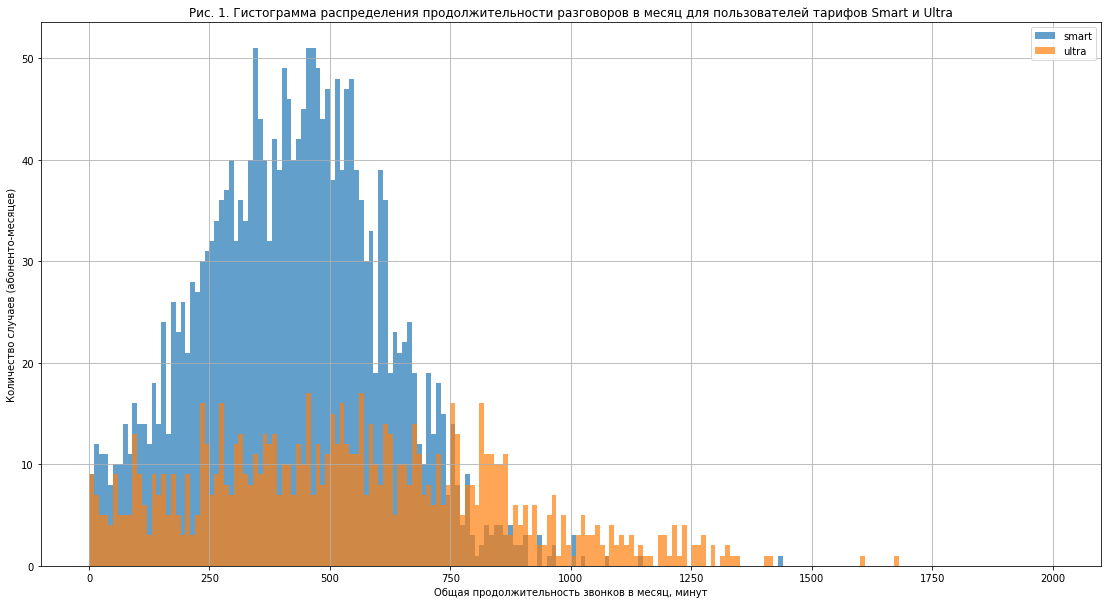

In [54]:
#построим гистрограмму распределения продолжительности разговоров для пользователей тарифа Smart (по 10 минут в корзине)
ax=month_pivot_table[month_pivot_table['tariff']=='smart']['calls_duration'].plot(
kind='hist', range=(0, 2000), bins=200, linewidth=7, label='smart', legend=True, figsize=(19, 10), grid=True, alpha=0.7)

#построим гистрограмму распределения продолжительности разговоров для пользователей тарифа Ultra (по 10 минут в корзине)
month_pivot_table[month_pivot_table['tariff']=='ultra']['calls_duration'].plot(
kind='hist', range=(0, 2000), bins=200, linewidth=7, label='ultra', legend=True, figsize=(19, 10), grid=True, ax=ax, alpha=0.7)

#добавим заголовок и названия осей
plt.title('Рис. 1. Гистограмма распределения продолжительности разговоров в месяц для пользователей тарифов Smart и Ultra');
plt.xlabel('Общая продолжительность звонков в месяц, минут');
plt.ylabel('Количество случаев (абоненто-месяцев)');

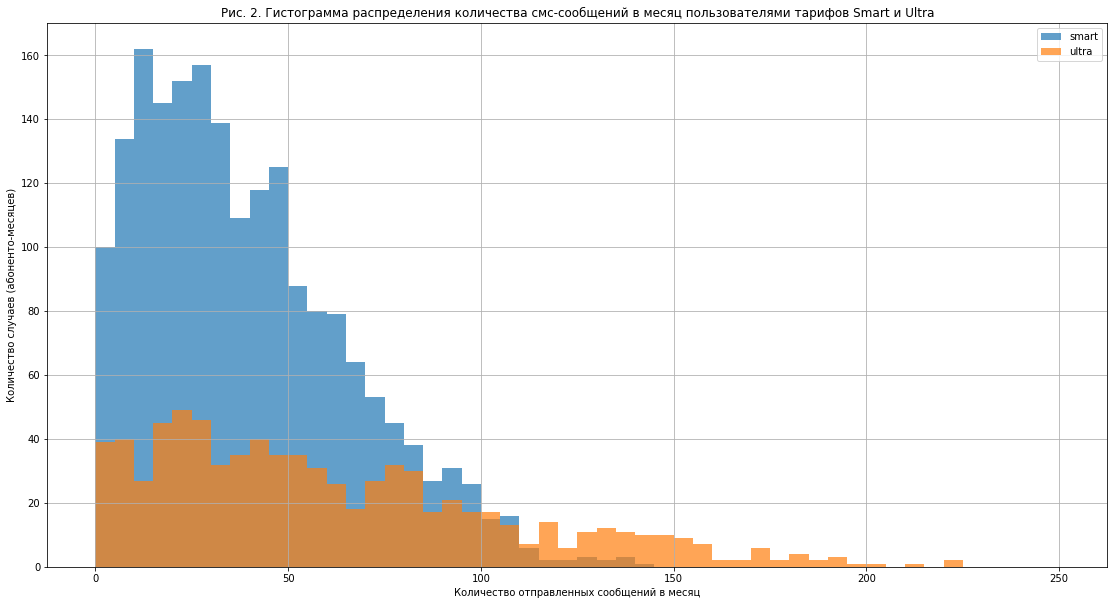

In [55]:
#построим гистрограмму распределения отправленных сообщений для пользователей тарифа Smart (по 5 смс в корзине)
ax=month_pivot_table[month_pivot_table['tariff']=='smart']['messages_count'].plot(
kind='hist', range=(0, 250), bins=50, linewidth=7, label='smart', legend=True, figsize=(19, 10), grid=True, alpha=0.7)

#построим гистрограмму распределения отправленных сообщений для пользователей тарифа Ultra (по 5 смс в корзине)
month_pivot_table[month_pivot_table['tariff']=='ultra']['messages_count'].plot(
kind='hist', range=(0, 250), bins=50, linewidth=7, label='ultra', legend=True, figsize=(19, 10), grid=True, ax=ax, alpha=0.7)

#добавим заголовок и названия осей
plt.title('Рис. 2. Гистограмма распределения количества смс-сообщений в месяц пользователями тарифов Smart и Ultra');
plt.xlabel('Количество отправленных сообщений в месяц');
plt.ylabel('Количество случаев (абоненто-месяцев)');

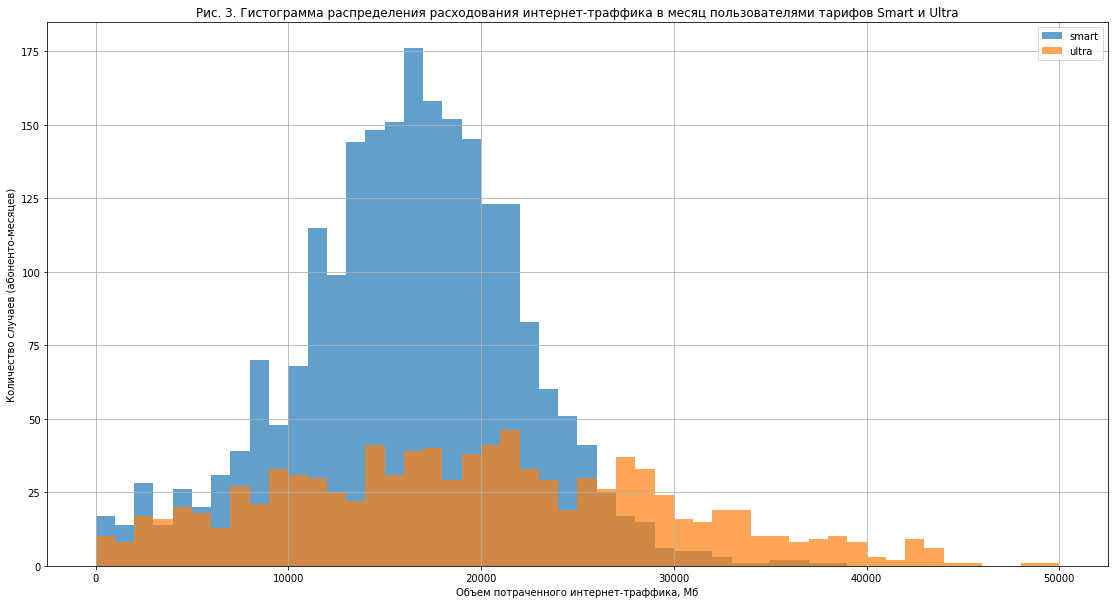

In [56]:
#построим гистрограмму распределения израсходованного за месяц объема интернет-траффика для пользователей тарифа Smart (по 1000 Мб в корзине)
ax=month_pivot_table[month_pivot_table['tariff']=='smart']['mb_used'].plot(
kind='hist', range=(0, 50000), bins=50, linewidth=3, label='smart', legend=True, figsize=(19, 10), grid=True, alpha=0.7)

#построим гистрограмму распределения израсходованного за месяц объема интернет-траффика для пользователей тарифа Ultra (по 1000 Мб в корзине)
month_pivot_table[month_pivot_table['tariff']=='ultra']['mb_used'].plot(
kind='hist', range=(0, 50000), bins=50, linewidth=7, label='ultra', legend=True, figsize=(19, 10), grid=True, ax=ax, alpha=0.7)

#добавим заголовок и названия осей
plt.title('Рис. 3. Гистограмма распределения расходования интернет-траффика в месяц пользователями тарифов Smart и Ultra');
plt.xlabel('Объем потраченного интернет-траффика, Мб');
plt.ylabel('Количество случаев (абоненто-месяцев)');

Анализируя полученные гистограммы, можно сделать следующие **выводы**:

- полученные гистограммы для продолжительности звонков и объема интернет-траффика имеют вид нормального распределения, при этом характер нормального распределения для тарифа Smart выражен более ярко по сравнению с тарифом Ultra, что, вероятно, обусловлено различными объемами выборок (выборка для тарифа Smart в два раза больше, чем для тарифа Ultra);
- распределение количества отправленных сообщений близок к распределению Пуассона, при этом характер распределения для тарифа Smart также выражен сильнее;
- для тарифа Smart большая часть звонков длится от 210 до 590 минут. При этом количество звонков с продолжительностью более 480 минут снижается более резко, чем количество звонков увеличивается от продолжительности 210 минут до 480 минут. Звонки от 750 минут встречаются совсем редко, свыше 1000 минут - единичные случаи;
- для тарифа Ultra звонки продолжительностью от 230 до 870 минут встречаются примерно с одинаковой частотой (около 10 абоненто месяцев на каждый интервал продолжительности с шагом 10 минут). В этом же интервале находится большая часть значений для тарифа Ultra. Реже встречаются звонки длительностью менее 230 минут, свыше 870 - еще реже и убывают к 1400 минутам;
- пользователи тарифа Smart чаще всего отправляют от 5 до 35 сообщений в месяц. При этом наблюдается локальный пик от 40 до 50 сообщений (50 сообщений - лимит тарифного плана). При увеличении отправленного в месяц количества сообщений от 50 до 115 количество случаев снижается.  Количество сообщений в интервале 115-145 сообщений в месяц с шагом 5 сообщений встречается 2-3 раза. Больше 145 сообщений в месяц не встречается;
- пользователи тарифа Ulra чаще всего отправляют от 15 до 30 сообщений в месяц (более 130 случаев в общей сложности). К 200 сообщениям в месяц количество случаев плавно снижается до 1 случая в корзине;
- чаще всего пользователи тарифа Smart используют от 16000 до 17000 Мб интернет-траффика (более 175 случаев). Большая часть пользователей использует от 13000 до 20000 Мб (более 140 случаев на каждый интервал с шагом 1000 Мб). Использование более 33000 Мб пользователями тарифа Smart наблюдается в единичных случаях;
- чаще всего пользователи тарифа Ultra используют от 13000 до 24000 Мб интернет-траффика (более 25 случаев на каждый интервал с шагом 1000 Мб). До 13000 Мб количество случаев растет (от 10 случаев в интервале от 0 до 100 Мб), после 24000 Мб снижается (до 1 случая в интервалах от 44000 Мб до 46000 Мб с шагом 1000 Мб). Как на этапе роста количества случаев, так и на этапе уменьшения наблюдаются локальные максимумы (9-12 тыс. Мб и 27-29 тыс. Мб соответственно). Максимальный объем траффика для пользователей тарифа Ultra не превышает 50000 Мб.


# 4. Проверка гипотез

В рамках проверки статистических гипотез требуется проверить:
- различается ли средняя выручка от тарифов Ultra и Smart;
- различается ли выручка от пользователей из Москвы и от пользователей из других регионов.

Для проверки гипотез воспользуемся критерием Стьюдента, так как он работает для выборок любых размеров.

Проверим гипотезу о различии средней выручки от тарифов Ultra и Smart.

***Нулевая гипотеза***: средние выручки от пользователей тарифов Ultra и Smart равны. </br>
***Альтернативная гипотеза***: средние выручки пользователей тарифов Ultra и Smart неравны.

Примем уровень значимости α=0.01.

In [57]:
alpha=0.01

#выполним проверку нулевой гипотезы о том, что выручка от тарифов Smart и Ultra одинакова
#так как дисперсии выборок для тарифов не равны, параметру equal_var зададим значение False
equal_revenue_check_tariffs=st.ttest_ind(month_pivot_table[month_pivot_table['tariff']=='smart']['revenue'],
                                month_pivot_table[month_pivot_table['tariff']=='ultra']['revenue'],
                                equal_var=False)

#выведем на экран значение pvalue
print('Вероятность получить наблюдаемый результат сравнения, если нулевая гипотеза верна:', equal_revenue_check_tariffs.pvalue)

#сравним полученное значение критерия с выбранным уровнем значимости
if equal_revenue_check_tariffs.pvalue < alpha:
    print('Результат противоречит нулевой гипотезе, отвергаем.')
if equal_revenue_check_tariffs.pvalue > alpha:
    print('Результат не противоречит нулевой гипотезе, не отвергаем.')

Вероятность получить наблюдаемый результат сравнения, если нулевая гипотеза верна: 4.2606313931076085e-250
Результат противоречит нулевой гипотезе, отвергаем.


Проверим гипотезу о различии средней выручки пользователей из Москвы и пользователей из других регионов.

***Нулевая гипотеза***: средняя выручка для пользователей из Москвы и для пользователей из других регионов одинакова. </br>
***Альтернативная гипотеза***: средняя выручка для пользователей из Москвы и для пользователей из других регионов неодинакова.

Перед началом теста определим объем выборки для пользователей из Москвы и из других регионов.

In [58]:
print('Объем выборки для пользователей из Москвы:', month_pivot_table[month_pivot_table['city']=='Москва']['revenue'].count())
print('Объем выборки для пользователей из регионов:', month_pivot_table[month_pivot_table['city']!='Москва']['revenue'].count())

Объем выборки для пользователей из Москвы: 611
Объем выборки для пользователей из регионов: 2603


Пользователей из регионов в 4 раза больше. При проверке нулевой гипотезы параметру equal_var зададим значение False.

In [59]:
alpha=0.01

#выполним проверку нулевой гипотезы о том, что выручка от пользователей из Москвы и пользователей из регионов одинакова
#так как дисперсии выборок для тарифов не равны, параметру equal_var зададим значение False
equal_revenue_check_Moscow_and_regions=st.ttest_ind(month_pivot_table[month_pivot_table['city']=='Москва']['revenue'],
                                month_pivot_table[month_pivot_table['city']!='Москва']['revenue'],
                                equal_var=False)

#выведем на экран значение pvalue
print('Вероятность получить наблюдаемый результат сравнения, если нулевая гипотеза верна:', equal_revenue_check_Moscow_and_regions.pvalue)

#сравним полученное значение критерия с выбранным уровнем значимости
if equal_revenue_check_Moscow_and_regions.pvalue < alpha:
    print('Результат противоречит нулевой гипотезе, отвергаем.')
if equal_revenue_check_Moscow_and_regions.pvalue > alpha:
    print('Результат не противоречит нулевой гипотезе, не отвергаем.')

Вероятность получить наблюдаемый результат сравнения, если нулевая гипотеза верна: 0.5257376663729298
Результат не противоречит нулевой гипотезе, не отвергаем.


**Выводы:**
- на имеющихся данных при уровне значимости 1% есть основания отвергнуть нулевую гипотезу о равенстве средних выручек от пользователей тарифов Smart и Ultra. Средние выручки не равны. С учетом того, что значение p_value меньше половины выбранного уровня значимости и средняя выборочная выручка от продажи тарифа Ultra выше, чем от тарифа Smart, можно сделать также вывод о том, что средняя выручка от тарифа Ultra для генеральной совокупности больше, чем от тарифа Smart. В связи с этим, компании "Мегалайн" следует вложить больше средств в рекламу тарифа Ultra.
- на имеющихся данных при уровне значимости 1% оснований отвергнуть нулевую гипотезу о равенстве средней выручки от пользователей из Москвы и от пользователей из регионов нет. Средние выручки равны с вероятностью 52%.


# 5. Общий вывод

В рамках анализа выборки об абонентах компании "Мегалайн" выполнено:
- для каждого из тарифов Smart и Ultra рассчитаны средние месячные показатели количества отправленных сообщений, продолжительности звонков, объема интернет-траффика; для этих же параметров определены среднеквадратические отклонения и дисперсия;
- для каждого из тарифов Smart и Ultra получено среднемесячное значение выручки и общая валовая выручка за 2018 год;
- на основании данных о статистике расходования минут, сообщений и мегабайт интернет-траффика выполнен анализ поведения абонентов;
- выполнена проверка влияния места жительства абонента на среднемесячную выручку;
- выявлен наиболее выгодный для компании тариф.

В результате исследования получены следующие выводы:
- средняя продолжительность разговоров в месяц для пользователей тарифа Smart составила 419 минут, количество отправленных смс - 39, объем интернет-траффика - 16216 Мб;
- средняя продолжительность разговоров в месяц для пользователей тарифа Ultra составила 545 минут, количество отправленных смс - 61, объем интернет-траффика - 19668 Мб;
- все средние (и медианные) показатели для тарифа Ultra не превышают объемов, предусмотренных тарифным планом. Для тарифа Smart в рамках тарифного плана остаются только продолжительность звонков и количество отправленных сообщений, в то время как средний объем интернет-траффика превышается предусмотренный тарифным планом на 5.6% (856 Мб), медианный - на 7.4% (1148 Мб);
- для рассматриваемой выборки максимальная продолжительность разговора для тарифа Ultra составляет лишь 56% от предусмотренной тарифным планом, максимальное количество отправленных сообщений - 22% от предусмотренного тарифным планом;
- все значения продолжительности разговоров и количества отправленных сообщений для тарифа Ultra не выходят за рамки установленного тарифным планом пакета. Дополнительная плата за интернет в общей сложности за 2018 год не превышает 119 тысяч, в то время как общая выручка за год от тарифа Ultra составляет 2 миллиона рублей. Основная часть выручки от тарифного плана Ultra (94%) - абонентская плата;
- общая выручка за 2018 год от тарифа Smart составила 2.8 миллиона, из которых абонентская плата составляет 1.5 миллиона - чуть больше половины;
- общая выручка за 2018 год от тарифа Smart больше аналогичного показателя для тарифа Ultra достигнута за счет большего количества абоненто-месяцев использования тарифа Smart (69% и 31% соответственно);
- место жительства абонента не влияет на среднемесячную выручку компании: с вероятностью 52% средняя выручка по Москве и по регионам будет примерно одинакова;
- среднемесячная выручка от тарифа Smart составила 1290 рублей, от тарифа Ultra составила 2070 рублей. Опираясь на результат проверки гипотез и значения среднемесячной выручки от двух тарифов, можно сделать вывод о том, что наиболее прибыльныv для компании является тариф Ultra.

<div align="center"><b> КОТИК ДЛЯ РЕВЬЮЕРА :) </b></div> 
<img src="https://simonscat.com/wp-content/uploads/2018/03/Screen-Shot-2018-03-14-at-12.50.08.png" align=center width=1000, heigth=100>